# Exploratory Data Analysis (EDA) – Chest X-ray Pneumonia Dataset

**Author:** [Dein Name]  
**Background:** M.Sc. Biology | Medical Student | Machine Learning Projects  
**Date:** July 2025  



##  Project Overview
This notebook provides a **comprehensive exploratory data analysis (EDA)** 
of the Chest X-ray Pneumonia dataset.  
The goal is to understand the dataset structure, class distribution, 
and sample images before applying deep learning methods.  



## Workflow
1. Dataset validation (train/val/test splits)  
2. Class distribution analysis (Normal vs Pneumonia)  
3. Visualization of class balance (bar charts, pie charts)  
4. Display of representative sample images  
5. Data augmentation preview (rotations, flips, etc.)  



## Outcomes
- Confirmed dataset structure and number of images per class  
- Identified class imbalance between Normal and Pneumonia cases  
- Visualized example chest X-rays for quick inspection  
- Prepared dataset for CNN model training  



## Context
This EDA notebook is the **first step** in a two-part project:  
1. **EDA (this notebook)** – understanding the data  
2. **Deep Learning (CNN model)** – training and evaluating a classifier  

Together, they demonstrate a complete workflow in **Machine Learning for Healthcare**.  



In [2]:
#---------------Import Libraries and Setup

import os
import random
import warnings
from pathlib import Path
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import kagglehub

/Users/cholponzhakshylykova/Desktop/SDS/SDS-CP021-pneumonia-detection/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ---------------- Configuration and Data Download
# Download the dataset using kagglehub
dataset_dir = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
DATA_ROOT = os.path.join(dataset_dir, "chest_xray")
print("DATA_ROOT:", DATA_ROOT)

# Configuration
warnings.filterwarnings("ignore")
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
os.makedirs("plots", exist_ok=True)


DATA_ROOT: /Users/cholponzhakshylykova/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray


### Explore data: 
    - look into data distribution
    - have a look into sample images
    - look into image properties

In [14]:
# Define ChestXrayEDA Class
class ChestXrayEDA:
    
    
    def __init__(self, data_root: str):
        self.data_root = Path(data_root)
        self.splits = ['train', 'val', 'test']
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.dataset_stats = {}
        self._validate_dataset_structure()
    
    def _validate_dataset_structure(self):
        """Validate that the dataset has the expected structure"""
        if not self.data_root.exists():
            raise FileNotFoundError(f"Dataset root not found: {self.data_root}")
        
        for split in self.splits:
            split_path = self.data_root / split
            if not split_path.exists():
                raise FileNotFoundError(f"Split directory not found: {split_path}")
            
            for cls in self.classes:
                class_path = split_path / cls
                if not class_path.exists():
                    raise FileNotFoundError(f"Class directory not found: {class_path}")
    
    def analyze_dataset_distribution(self) -> Dict:
        """Analyze the distribution of images across splits and classes"""
        stats = {}
        
        for split in self.splits:
            stats[split] = {}
            split_path = self.data_root / split
            
            for cls in self.classes:
                class_path = split_path / cls
                image_files = [f for f in class_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
                stats[split][cls] = len(image_files)
            
            stats[split]['total'] = sum(stats[split].values())
        
        self.dataset_stats = stats

        print("="*60)
        print("DATASET DISTRIBUTION ANALYSIS")
        print("="*60)
        
        for split in self.splits:
            print(f"\n{split.upper()} SET:")
            for cls in self.classes:
                count = stats[split][cls]
                percentage = (count / stats[split]['total']) * 100
                print(f"  {cls:>10}: {count:>5} images ({percentage:.1f}%)")
            print(f"  {'TOTAL':>10}: {stats[split]['total']:>5} images")
        
        # Overall statistics
        total_images = sum(stats[split]['total'] for split in self.splits)
        total_normal = sum(stats[split]['NORMAL'] for split in self.splits)
        total_pneumonia = sum(stats[split]['PNEUMONIA'] for split in self.splits)
        
        print(f"\nOVERALL DATASET:")
        print(f"  {'NORMAL':>10}: {total_normal:>5} images ({(total_normal/total_images)*100:.1f}%)")
        print(f"  {'PNEUMONIA':>10}: {total_pneumonia:>5} images ({(total_pneumonia/total_images)*100:.1f}%)")
        print(f"  {'TOTAL':>10}: {total_images:>5} images")
        
        # Class imbalance analysis
        imbalance_info = []
        imbalance_threshold = 1.2
        
        for split in self.splits:
            n_normal = stats[split]['NORMAL']
            n_pneumonia = stats[split]['PNEUMONIA']
            ratio = max(n_normal, n_pneumonia) / (min(n_normal, n_pneumonia) + 1e-9)
            imbalance_info.append((split, ratio))
        
        overall_ratio = max(total_normal, total_pneumonia) / (min(total_normal, total_pneumonia) + 1e-9)
        
        print("\nCLASS IMBALANCE ANALYSIS & RECOMMENDATION:")
        for split, ratio in imbalance_info:
            print(f"  {split.upper()} set imbalance ratio: {ratio:.2f} (max/min)")
        print(f"  OVERALL imbalance ratio: {overall_ratio:.2f} (max/min)")
        
        if overall_ratio > imbalance_threshold:
            print("\nRecommendation: There is a significant class imbalance.")
            print("It is recommended to use OVERSAMPLING (or class weighting) during model training to address this.")
        else:
            print("\nNo significant class imbalance detected.")
        
        return stats
    
    def visualize_distribution(self):
        """Create comprehensive visualizations of dataset distribution"""
        if not self.dataset_stats:
            self.analyze_dataset_distribution()
        
        splits = list(self.dataset_stats.keys())
        normal_counts = [self.dataset_stats[split]['NORMAL'] for split in splits]
        pneumonia_counts = [self.dataset_stats[split]['PNEUMONIA'] for split in splits]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Stacked bar chart
        x = np.arange(len(splits))
        width = 0.6
        
        axes[0, 0].bar(x, normal_counts, width, label='NORMAL', alpha=0.8)
        axes[0, 0].bar(x, pneumonia_counts, width, bottom=normal_counts, label='PNEUMONIA', alpha=0.8)
        axes[0, 0].set_xlabel('Dataset Split')
        axes[0, 0].set_ylabel('Number of Images')
        axes[0, 0].set_title('Dataset Distribution by Split (Stacked)')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels([s.capitalize() for s in splits])
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # Grouped bar chart
        width = 0.35
        axes[0, 1].bar(x - width/2, normal_counts, width, label='NORMAL', alpha=0.8)
        axes[0, 1].bar(x + width/2, pneumonia_counts, width, label='PNEUMONIA', alpha=0.8)
        axes[0, 1].set_xlabel('Dataset Split')
        axes[0, 1].set_ylabel('Number of Images')
        axes[0, 1].set_title('Class Distribution Comparison')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels([s.capitalize() for s in splits])
        axes[0, 1].legend()
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # Overall pie chart
        total_normal = sum(normal_counts)
        total_pneumonia = sum(pneumonia_counts)
        
        axes[1, 0].pie([total_normal, total_pneumonia], labels=['NORMAL', 'PNEUMONIA'],
                       autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        axes[1, 0].set_title('Overall Class Distribution')
        
        # Imbalance ratio chart
        imbalance_ratios = []
        split_labels = []
        
        for split in splits:
            normal = self.dataset_stats[split]['NORMAL']
            pneumonia = self.dataset_stats[split]['PNEUMONIA']
            ratio = pneumonia / normal if normal > 0 else 0
            imbalance_ratios.append(ratio)
            split_labels.append(f"{split.capitalize()}\n({pneumonia}:{normal})")
        
        bars = axes[1, 1].bar(range(len(splits)), imbalance_ratios, alpha=0.8)
        axes[1, 1].set_xlabel('Dataset Split')
        axes[1, 1].set_ylabel('Pneumonia:Normal Ratio')
        axes[1, 1].set_title('Class Imbalance by Split')
        axes[1, 1].set_xticks(range(len(splits)))
        axes[1, 1].set_xticklabels(split_labels)
        axes[1, 1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Balanced')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, ratio) in enumerate(zip(bars, imbalance_ratios)):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                            f'{ratio:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        fig.savefig(os.path.join("plots", "dataset_distribution.png"), dpi=300, bbox_inches='tight')
        plt.show()
    
    def sample_images_visualization(self, n_samples: int = 8):
        """Display sample images from each class"""
        fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))
        
        for class_idx, class_name in enumerate(self.classes):
            class_path = self.data_root / 'train' / class_name
            image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
            sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
            
            for img_idx, img_path in enumerate(sampled_files):
                try:
                    img = Image.open(img_path).convert('L')
                    axes[class_idx, img_idx].imshow(img, cmap='gray')
                    axes[class_idx, img_idx].set_title(f'{class_name}\n{img_path.name}', fontsize=10)
                    axes[class_idx, img_idx].axis('off')
                except Exception as e:
                    axes[class_idx, img_idx].text(0.5, 0.5, f'Error loading\n{img_path.name}',
                                                 ha='center', va='center', transform=axes[class_idx, img_idx].transAxes)
                    axes[class_idx, img_idx].axis('off')
        
        plt.suptitle('Sample Images from Each Class', fontsize=16)
        plt.tight_layout()
        fig.savefig(os.path.join("plots", "sample_images.png"), dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_image_properties(self, sample_size: int = 100):
        """Analyze image properties like dimensions, file sizes, etc."""
        print("\n" + "="*60)
        print("IMAGE PROPERTIES ANALYSIS")
        print("="*60)
        
        properties = {split: {cls: {'widths': [], 'heights': [], 'file_sizes': []} 
                             for cls in self.classes} for split in self.splits}
        
        for split in self.splits:
            for cls in self.classes:
                class_path = self.data_root / split / cls
                image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
                
                # Sample random images for analysis
                sample_files = random.sample(image_files, min(sample_size, len(image_files)))
                
                for img_path in sample_files:
                    try:
                        with Image.open(img_path) as img:
                            width, height = img.size
                            properties[split][cls]['widths'].append(width)
                            properties[split][cls]['heights'].append(height)
                            properties[split][cls]['file_sizes'].append(img_path.stat().st_size)
                    except Exception as e:
                        continue
        
        # Display statistics
        for split in self.splits:
            print(f"\n{split.upper()} SET:")
            for cls in self.classes:
                widths = properties[split][cls]['widths']
                heights = properties[split][cls]['heights']
                file_sizes = properties[split][cls]['file_sizes']
                
                if widths:  # Only if we have data
                    print(f"  {cls}:")
                    print(f"    Width:  {np.mean(widths):.0f} ± {np.std(widths):.0f} px (range: {np.min(widths)}-{np.max(widths)})")
                    print(f"    Height: {np.mean(heights):.0f} ± {np.std(heights):.0f} px (range: {np.min(heights)}-{np.max(heights)})")
                    print(f"    Size:   {np.mean(file_sizes)/1024:.1f} ± {np.std(file_sizes)/1024:.1f} KB")
        
        return properties
    
    def plot_image_properties(self, properties: Dict):
        """Plot image properties distribution"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Collect all data for plotting
        all_widths = {'NORMAL': [], 'PNEUMONIA': []}
        all_heights = {'NORMAL': [], 'PNEUMONIA': []}
        all_file_sizes = {'NORMAL': [], 'PNEUMONIA': []}
        
        for split in self.splits:
            for cls in self.classes:
                all_widths[cls].extend(properties[split][cls]['widths'])
                all_heights[cls].extend(properties[split][cls]['heights'])
                all_file_sizes[cls].extend(properties[split][cls]['file_sizes'])
        
        # Width distribution
        axes[0, 0].hist([all_widths['NORMAL'], all_widths['PNEUMONIA']], 
                       bins=30, alpha=0.7, label=['NORMAL', 'PNEUMONIA'])
        axes[0, 0].set_xlabel('Width (pixels)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Image Width Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Height distribution
        axes[0, 1].hist([all_heights['NORMAL'], all_heights['PNEUMONIA']], 
                       bins=30, alpha=0.7, label=['NORMAL', 'PNEUMONIA'])
        axes[0, 1].set_xlabel('Height (pixels)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Image Height Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # File size distribution
        axes[0, 2].hist([np.array(all_file_sizes['NORMAL'])/1024, np.array(all_file_sizes['PNEUMONIA'])/1024], 
                       bins=30, alpha=0.7, label=['NORMAL', 'PNEUMONIA'])
        axes[0, 2].set_xlabel('File Size (KB)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title('File Size Distribution')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)
        
        # Aspect ratio analysis
        aspect_ratios = {'NORMAL': [], 'PNEUMONIA': []}
        for cls in self.classes:
            for w, h in zip(all_widths[cls], all_heights[cls]):
                if h > 0:
                    aspect_ratios[cls].append(w/h)
        
        axes[1, 0].hist([aspect_ratios['NORMAL'], aspect_ratios['PNEUMONIA']], 
                       bins=30, alpha=0.7, label=['NORMAL', 'PNEUMONIA'])
        axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Aspect Ratio Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
        
        # Box plots for dimensions
        width_data = [all_widths['NORMAL'], all_widths['PNEUMONIA']]
        height_data = [all_heights['NORMAL'], all_heights['PNEUMONIA']]
        
        axes[1, 1].boxplot(width_data, labels=['NORMAL', 'PNEUMONIA'])
        axes[1, 1].set_ylabel('Width (pixels)')
        axes[1, 1].set_title('Width Distribution (Box Plot)')
        axes[1, 1].grid(alpha=0.3)
        
        axes[1, 2].boxplot(height_data, labels=['NORMAL', 'PNEUMONIA'])
        axes[1, 2].set_ylabel('Height (pixels)')
        axes[1, 2].set_title('Height Distribution (Box Plot)')
        axes[1, 2].grid(alpha=0.3)
        
        plt.tight_layout()
        fig.savefig(os.path.join("plots", "image_properties.png"), dpi=300, bbox_inches='tight')
        plt.show()

print(" ChestXrayEDA class defined successfully!")

 ChestXrayEDA class defined successfully!


In [17]:
# Initialize EDA Object and Validate Dataset

eda = ChestXrayEDA(DATA_ROOT)


In [18]:
# Analyze Dataset Distribution
dataset_stats = eda.analyze_dataset_distribution()

DATASET DISTRIBUTION ANALYSIS

TRAIN SET:
      NORMAL:  1341 images (25.7%)
   PNEUMONIA:  3875 images (74.3%)
       TOTAL:  5216 images

VAL SET:
      NORMAL:     8 images (50.0%)
   PNEUMONIA:     8 images (50.0%)
       TOTAL:    16 images

TEST SET:
      NORMAL:   234 images (37.5%)
   PNEUMONIA:   390 images (62.5%)
       TOTAL:   624 images

OVERALL DATASET:
      NORMAL:  1583 images (27.0%)
   PNEUMONIA:  4273 images (73.0%)
       TOTAL:  5856 images

CLASS IMBALANCE ANALYSIS & RECOMMENDATION:
  TRAIN set imbalance ratio: 2.89 (max/min)
  VAL set imbalance ratio: 1.00 (max/min)
  TEST set imbalance ratio: 1.67 (max/min)
  OVERALL imbalance ratio: 2.70 (max/min)

Recommendation: There is a significant class imbalance.
It is recommended to use OVERSAMPLING (or class weighting) during model training to address this.


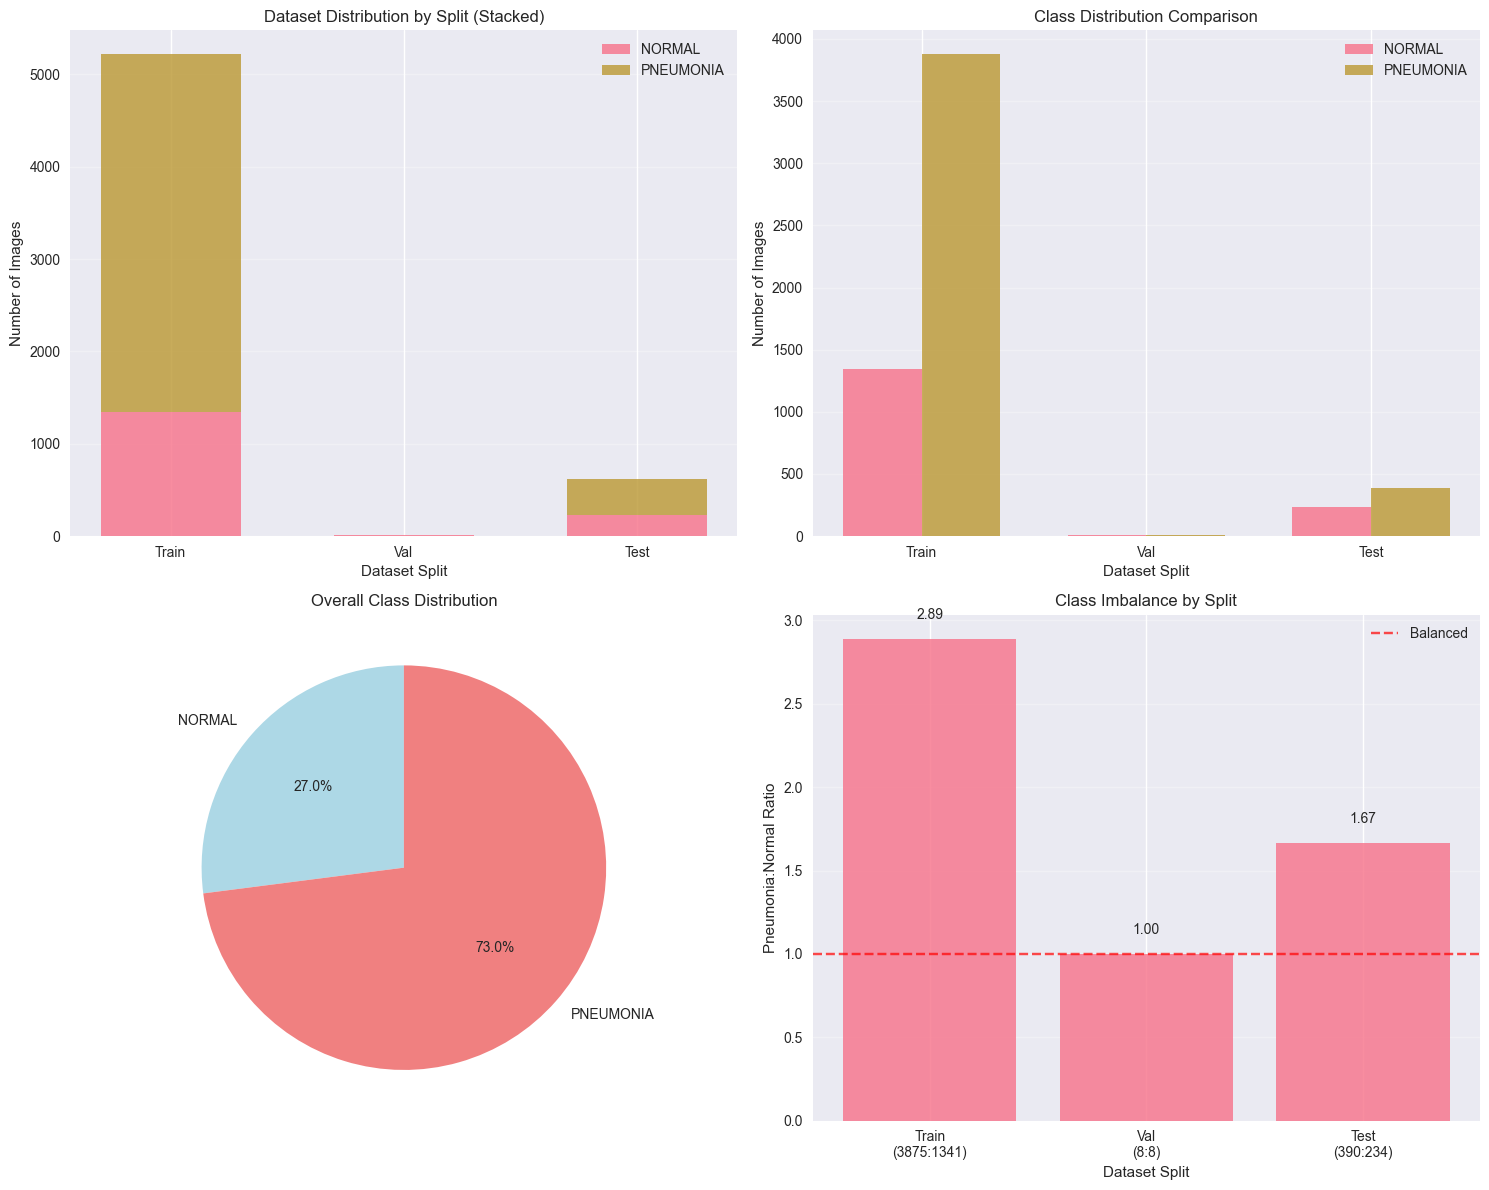

In [19]:
# Visualize Dataset Distribution

eda.visualize_distribution()


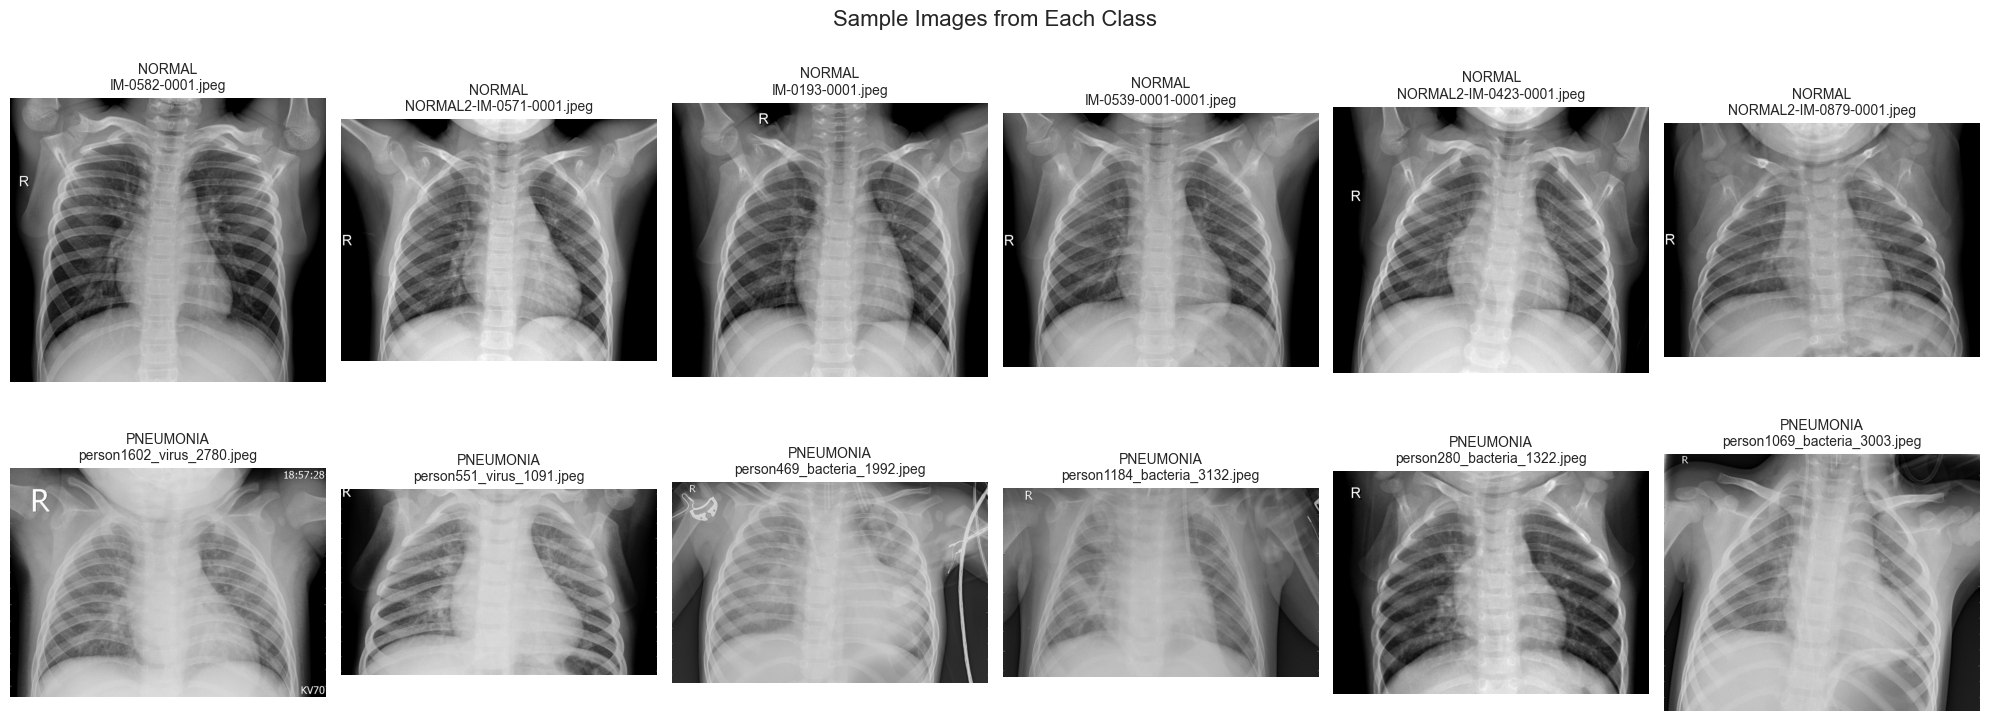

In [20]:
#Display Sample Images

eda.sample_images_visualization(n_samples=6)

In [21]:
# Analyze Image Properties

properties = eda.analyze_image_properties(sample_size=150)


IMAGE PROPERTIES ANALYSIS

TRAIN SET:
  NORMAL:
    Width:  1667 ± 296 px (range: 1064-2534)
    Height: 1395 ± 349 px (range: 842-2663)
    Size:   611.7 ± 287.6 KB
  PNEUMONIA:
    Width:  1205 ± 305 px (range: 452-2096)
    Height: 819 ± 282 px (range: 180-1928)
    Size:   83.4 ± 52.9 KB

VAL SET:
  NORMAL:
    Width:  1480 ± 207 px (range: 1240-1776)
    Height: 1192 ± 167 px (range: 928-1416)
    Size:   293.6 ± 117.8 KB
  PNEUMONIA:
    Width:  1217 ± 215 px (range: 968-1664)
    Height: 814 ± 175 px (range: 592-1128)
    Size:   76.3 ± 22.0 KB

TEST SET:
  NORMAL:
    Width:  1773 ± 345 px (range: 1094-2720)
    Height: 1344 ± 414 px (range: 650-2713)
    Size:   200.3 ± 114.8 KB
  PNEUMONIA:
    Width:  1144 ± 205 px (range: 728-2000)
    Height: 772 ± 203 px (range: 344-1456)
    Size:   73.9 ± 39.5 KB


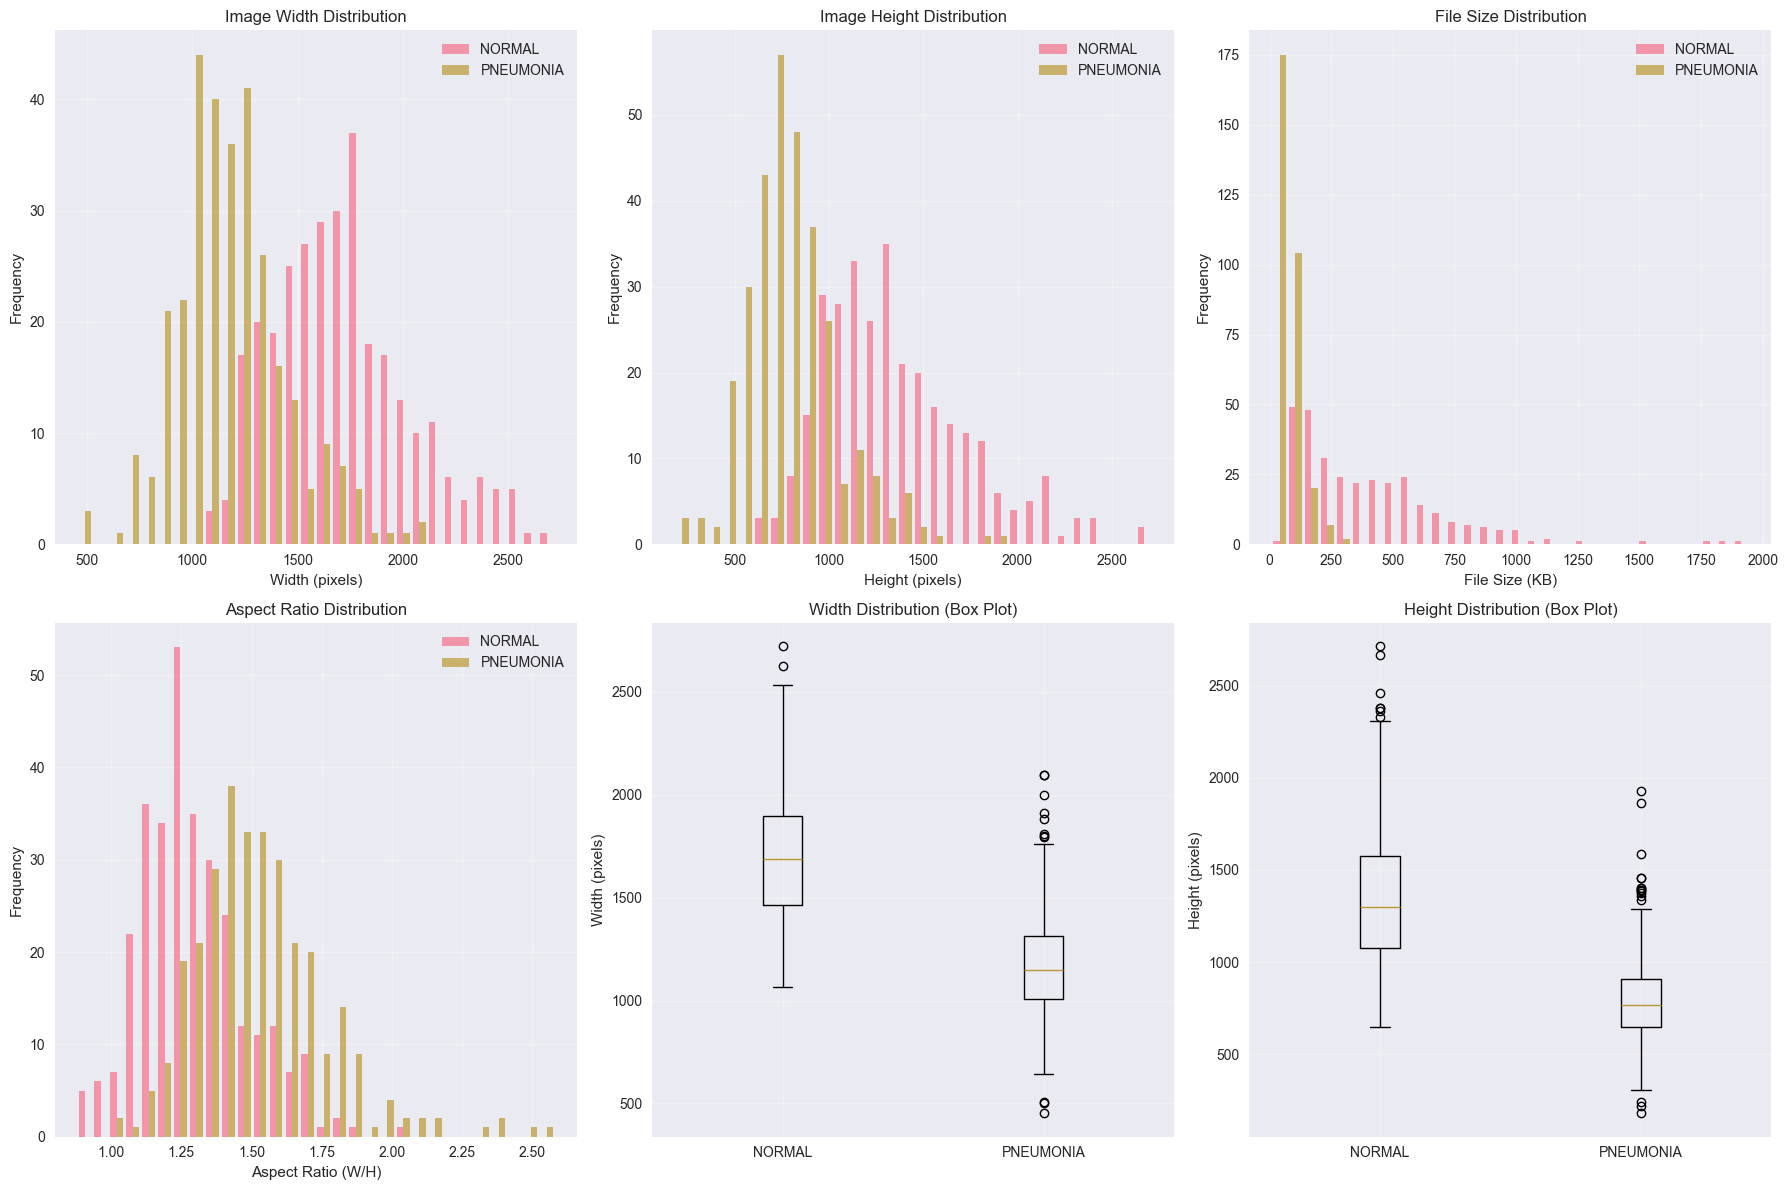

In [22]:
# Plot Image Properties

eda.plot_image_properties(properties)

### Data augmentation


 DEMONSTRATING DATA AUGMENTATION...


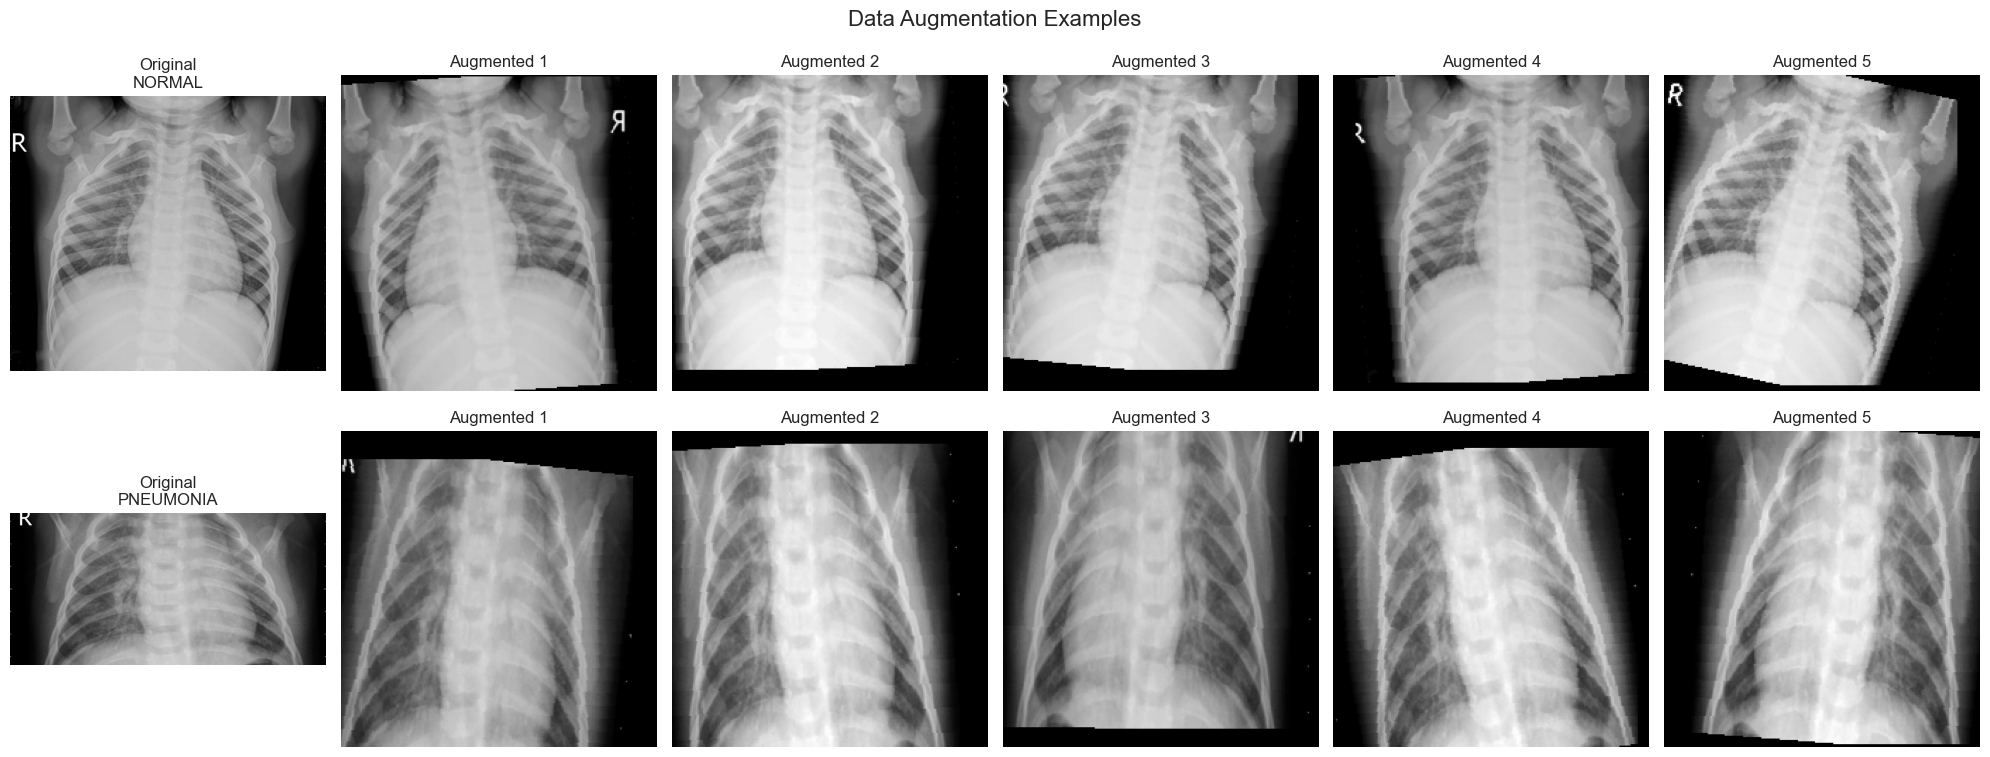

In [23]:
# Data Augmentation Visualization
def visualize_augmentations(data_root: str, n_augmentations: int = 5):
    """Visualize data augmentation transformations"""
    print("\n DEMONSTRATING DATA AUGMENTATION...")
    
    # Define augmentation transforms
    transform_augment = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ])
    
    # Select sample images from both classes
    fig, axes = plt.subplots(2, n_augmentations + 1, figsize=(20, 8))
    
    for class_idx, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        sample_path = Path(data_root) / 'train' / class_name
        sample_files = list(sample_path.glob('*.jpeg')) + list(sample_path.glob('*.jpg'))
        sample_img_path = random.choice(sample_files)
        
        # Load original image
        original_img = Image.open(sample_img_path).convert('L')
        
        # Show original
        axes[class_idx, 0].imshow(original_img, cmap='gray')
        axes[class_idx, 0].set_title(f'Original\n{class_name}')
        axes[class_idx, 0].axis('off')
        
        # Show augmented versions
        for i in range(n_augmentations):
            augmented = transform_augment(original_img)
            axes[class_idx, i + 1].imshow(augmented.squeeze(), cmap='gray')
            axes[class_idx, i + 1].set_title(f'Augmented {i + 1}')
            axes[class_idx, i + 1].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=16)
    plt.tight_layout()
    fig.savefig(os.path.join("plots", "data_augmentation.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Apply augmentation visualization
visualize_augmentations(DATA_ROOT, n_augmentations=5)